In [1]:
import cv2
import os
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# from keras_preprocessing.image import ImageDataGenerator,load_img, img_to_array
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from skimage.feature import hog

In [2]:
import os
import glob

# Specify the path to your main brain tumor folder
main_folder_path = "../Project/cleaned_data/Train"

# Define the subfolders for benign and malignant tumors
benign_folder = os.path.join(main_folder_path, "benign")
malignant_folder = os.path.join(main_folder_path, "malignant")

# Function to count the number of image files in a folder
def count_images_in_folder(folder_path):
    image_extensions = ["*.jpg", "*.jpeg", "*.png", "*.gif", "*.bmp"]  # Add more extensions if needed
    total_count = 0

    for ext in image_extensions:
        pattern = os.path.join(folder_path, ext)
        image_files = glob.glob(pattern)
        total_count += len(image_files)

    return total_count

# Count images in the benign and malignant folders
benign_count = count_images_in_folder(benign_folder)
malignant_count = count_images_in_folder(malignant_folder)

# Print the counts
print(f"Total number of benign tumor images: {benign_count}")
print(f"Total number of malignant tumor images: {malignant_count}")


Total number of benign tumor images: 1469
Total number of malignant tumor images: 1469


In [3]:
image_path = '../Project/cleaned_data/Train/malignant/y369.jpg'
#Read image as Grayscale
image = cv2.imread(image_path,0)

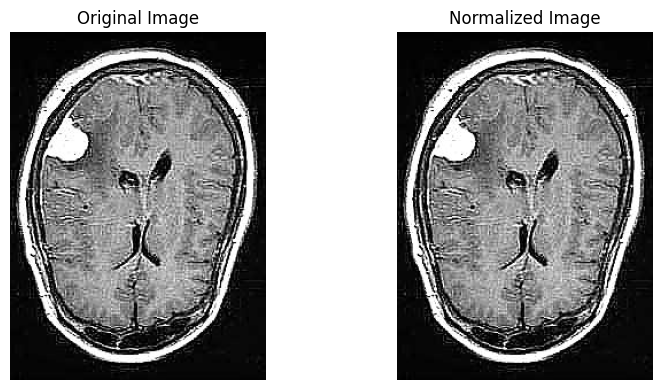

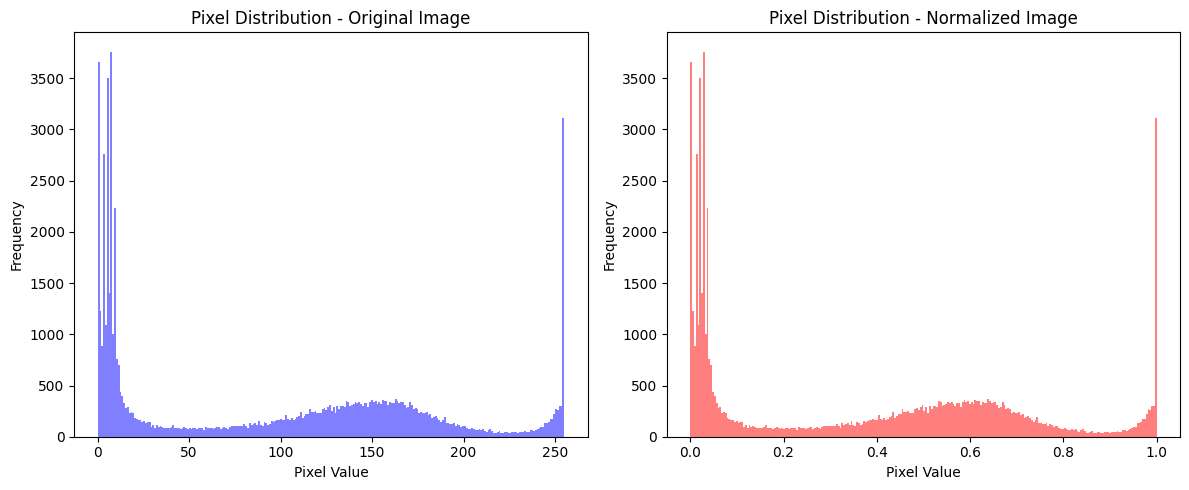

(303, 223)


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    # Convert image to floating point
    image_float = image.astype(float)

    # Find the minimum and maximum pixel values
    min_val = np.min(image_float.ravel())
    max_val = np.max(image_float.ravel())

    # Apply normalization
    normalized = (image_float - min_val) / (max_val - min_val)

    return normalized

normalized_image = normalize_image(image)

# Step 1: Display original and normalized images
plt.figure(figsize=(12, 4))

# Original image
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Normalized image
plt.subplot(1, 3, 2)
plt.title('Normalized Image')
# If the original image is grayscale, make sure we still plot it in grayscale
if len(normalized_image.shape) == 2:
    plt.imshow(normalized_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor((normalized_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.show()

# Step 4: Plot the pixel distribution (histogram) for the original image
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Pixel Distribution - Original Image')
plt.hist(image.ravel(), bins=256, color='blue', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Step 5: Plot the pixel distribution (histogram) for the normalized image
plt.subplot(1, 2, 2)
plt.title('Pixel Distribution - Normalized Image')
plt.hist(normalized_image.ravel(), bins=256, range=(0,1), color='red', alpha=0.5)
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

print(normalized_image.shape)

(2985, 4096)


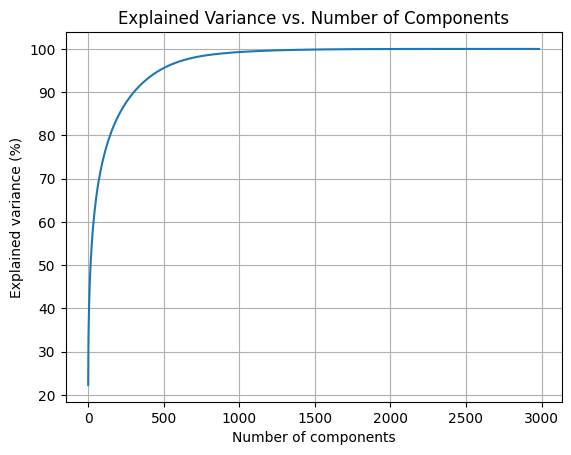

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA

# Define a function to load and preprocess images
def load_and_preprocess_images(directory, target_size=(64, 64)):
    images = []
    for subdir, _, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(subdir, file)
            if filepath.endswith(".jpg"):
                # print(filepath)
                # Load image in grayscale
                img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
                
                # Resize image to a standard size
                img = cv2.resize(img, target_size)
                
                # Flatten and append to the images list
                images.append(img.flatten())
    
    return np.array(images)

# Load and preprocess images from the specified directory
images_arr = load_and_preprocess_images("../Project/cleaned_data")
print(images_arr.shape) #231 rows means 231 total data, 64*64 image size for columns

# Perform PCA
pca = PCA(n_components= min(images_arr.shape))
pca.fit(images_arr)

# Plot the explained variance
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance (%)')
plt.title('Explained Variance vs. Number of Components')
plt.show()


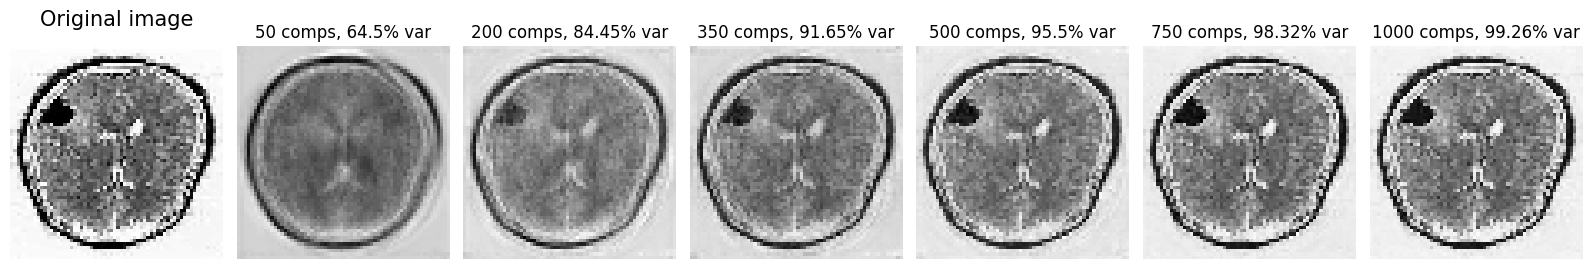

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# List of different dimensions (number of principal components) for PCA
dimensions = [50, 200, 350, 500, 750, 1000]

normalized_image = normalize_image(image)

# `normalized_image` are images that have been pre-processed to have pixel values between 0 and 1.
images = normalized_image

actual_image = normalized_image

# Reshape the flattened image to its original 2D shape
reshaped_actual_image = actual_image.reshape(normalized_image.shape)
reshaped_actual_image =cv2.resize(reshaped_actual_image, (64,64), cv2.INTER_CUBIC)

# Create a grid of subplots with 1 row and 6 columns. This will be used to display the original and PCA-reconstructed images.
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16, 8))

# Display the reshaped original image in the first subplot
ax = axes[0]
ax.imshow(reshaped_actual_image, cmap='gray_r')
ax.set_title('Original image', fontsize=15, pad=15)
ax.axis('off')

# Iterate over the specified dimensions and perform PCA
for i, dim in enumerate(dimensions):
    
    # Perform PCA for the current number of components (dim)
    pca = PCA(n_components=dim)
    pca_reduced = pca.fit_transform(images_arr) # Reduce dimensionality
    # print(pca_reduced)
    pca_recovered = pca.inverse_transform(pca_reduced) # Reconstruct images from reduced dimensions

    # Reshape the PCA-reconstructed data to get the image format
    image_pca = pca_recovered[47,:].reshape([64, 64]) #access the 48th image from images_arr
    
    # Display the PCA-reconstructed image
    ax = axes[i+1]  # Access the right subplot directly
    ax.imshow(image_pca, cmap='gray_r')
    
    # Calculate and display the cumulative explained variance by the PCA model
    var = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
    var = round(var, 2) # Round to two decimal places
    ax.set_title(f'{dim} comps, {var}% var', fontsize=12)
    ax.axis('off')


# Adjust the layout and padding of the plot for a better presentation
fig.tight_layout(pad=1.0)

# Show the plot
plt.show()
